In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn


train = datasets.MNIST(root='./data', train=True, download=True)

test = datasets.MNIST(root='./data', train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



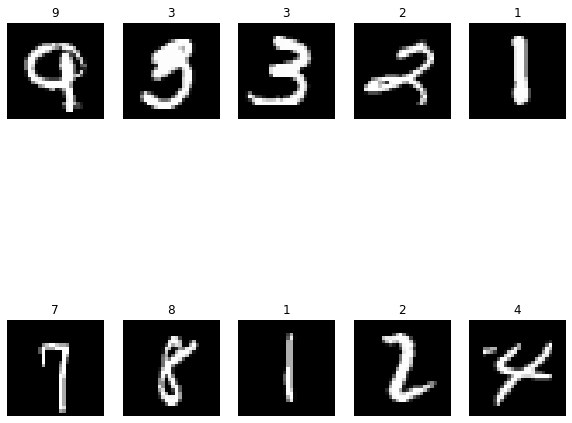

In [2]:
ind = np.random.randint(len(train), size = 10)
plt.figure(figsize = (10,10))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(train.data[ind[i]], cmap = 'gray')
  plt.title(train.targets[ind[i]].item())
  plt.axis('off')

In [3]:
from torchvision import transforms


transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))])


train.transform = transform
test.transform = transform

train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 128, shuffle = True)

train_loader.dataset.train_data.shape

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
def train_model(train, val, model, loss_fn, optim, num_epochs):
  tr_losses = []
  val_losses = []
  tr_acc = []
  val_acc = []
  for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(tqdm(train)):  
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        #print(outputs[0])
        preds = torch.argmax(outputs, 1) 

        total += labels.size(0)
        correct += (labels == preds).sum().item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()

    print ('Epoch [{}/{}], Loss: {:.4f}, Acc: {:.2f} %.' 
                   .format(epoch+1, num_epochs, loss.item(),100 * correct / total)) 

    tr_acc.append(correct/total)
    tr_losses.append(loss.item())

    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in val:      
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          predicted = torch.argmax(outputs, 1)
          total += labels.size(0)
          correct += (predicted.cpu() == labels.cpu()).sum().item()

      val_losses.append(loss_fn(outputs, labels).cpu().item())
            
    val_acc.append(correct/total)
    print('Accuracy of the network on the validation images: {} %'.format(100 * correct / total))
  return tr_losses, tr_acc, val_losses, val_acc

In [6]:
class ResBlocks(nn.Module):
  def __init__(self, in_channels, out_channels, downsample):
    super().__init__()

    if downsample:          # если размер входного и получившегося тензора разный
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
            )
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
            nn.BatchNorm2d(out_channels)
        )
    else:
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.shortcut = nn.Sequential()

    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    

  def forward(self, input):
    shortcut = self.shortcut(input)
    input = (self.conv1(input))
    input = (self.conv2(input))
    input = input + shortcut
    return nn.ReLU()(input)


In [7]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU())

        self.layer2 = nn.Sequential(
            ResBlocks(64, 64, downsample = False),
            ResBlocks(64, 64, downsample = False)
        )

        self.layer3 = nn.Sequential(
            ResBlocks(64, 128, downsample = True),
            ResBlocks(128, 128, downsample = False)
        )

        self.pool = nn.AvgPool2d(1)
        self.fc = nn.Linear(25088, num_classes)

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.pool(x)
      x = x.reshape(x.size(0), -1)
      #print(x.shape)
      out = self.fc(x)
      return out


In [8]:
ResNet = ResNet18(10).to(device)

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet.parameters(), lr=1e-3)

In [10]:
from torchsummary import summary
summary(ResNet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          36,928
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          36,928
       BatchNorm2d-8           [-1, 64, 28, 28]             128
              ReLU-9           [-1, 64, 28, 28]               0
        ResBlocks-10           [-1, 64, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          36,928
      BatchNorm2d-12           [-1, 64, 28, 28]             128
             ReLU-13           [-1, 64, 28, 28]               0
           Conv2d-14           [-1, 64,

In [11]:
num_epochs = 12

In [12]:
%%time
train_loss, train_acc, val_loss, val_acc = train_model(train_loader, test_loader, ResNet, criterion, optimizer, num_epochs)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/12], Loss: 0.0153, Acc: 93.57 %.
Accuracy of the network on the validation images: 98.13 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [2/12], Loss: 0.1954, Acc: 97.90 %.
Accuracy of the network on the validation images: 97.73 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3/12], Loss: 0.0096, Acc: 98.52 %.
Accuracy of the network on the validation images: 98.09 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [4/12], Loss: 0.0457, Acc: 98.77 %.
Accuracy of the network on the validation images: 98.12 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [5/12], Loss: 0.0050, Acc: 98.99 %.
Accuracy of the network on the validation images: 99.05 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [6/12], Loss: 0.0341, Acc: 99.25 %.
Accuracy of the network on the validation images: 98.55 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [7/12], Loss: 0.0036, Acc: 99.35 %.
Accuracy of the network on the validation images: 98.91 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [8/12], Loss: 0.0579, Acc: 99.37 %.
Accuracy of the network on the validation images: 98.9 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [9/12], Loss: 0.0021, Acc: 99.43 %.
Accuracy of the network on the validation images: 98.75 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [10/12], Loss: 0.0017, Acc: 99.50 %.
Accuracy of the network on the validation images: 98.92 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [11/12], Loss: 0.0023, Acc: 99.66 %.
Accuracy of the network on the validation images: 98.82 %


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [12/12], Loss: 0.0008, Acc: 99.61 %.
Accuracy of the network on the validation images: 98.58 %
CPU times: user 5min 42s, sys: 2.71 s, total: 5min 45s
Wall time: 5min 51s


Text(0.5, 1.0, 'val accuracy')

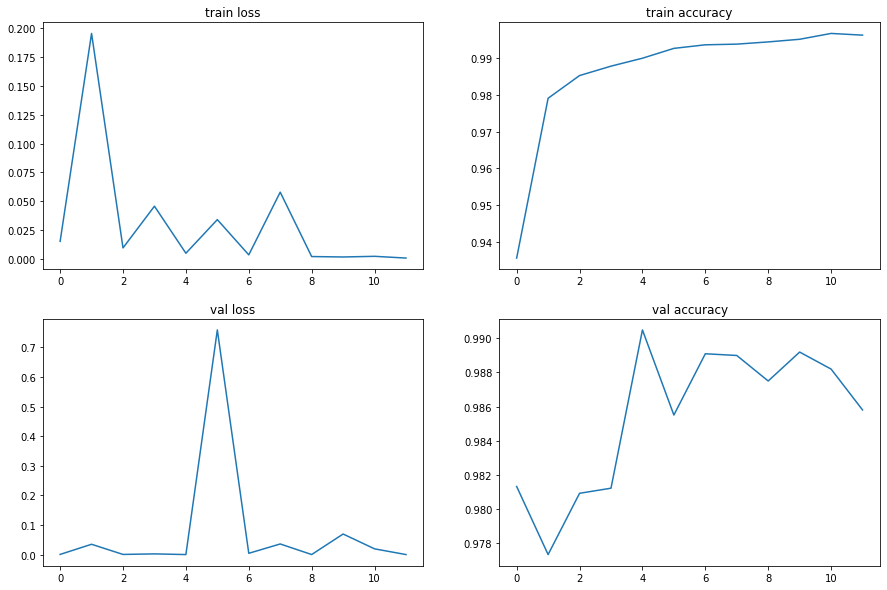

In [13]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot([i for i in range(num_epochs)], train_loss)
ax[0,0].set_title('train loss')
ax[0,1].plot([i for i in range(num_epochs)], train_acc)
ax[0,1].set_title('train accuracy')
ax[1,0].plot([i for i in range(num_epochs)], val_loss)
ax[1,0].set_title('val loss')
ax[1,1].plot([i for i in range(num_epochs)], val_acc)
ax[1,1].set_title('val accuracy')

In [ ]:
path = 'my_model.pth'

In [ ]:
torch.save(ResNet.state_dict(), path)

In [ ]:
from google.colab import files
files.download('my_model.pth') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>